In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 목차
1. 데이터셋 확인
2. 탐색적 데이터 분석 - EDA
3. feature engineering
4. model
5. train and predict
6. evaluate

## 1. Dataset 확인

In [3]:
df_train = pd.read_csv('./titanic/train.csv')
df_test  = pd.read_csv('./titanic/test.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare 이며, 예측하려는 target label 은 Survived 입니다.

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.1 Null Data Check

In [6]:
for col in df_train.columns:
    msg = 'column: {:>12}\t Percent of NaN value: {:.2f}%'.format(
        col, 
        100 * (df_train[col].isnull().sum() / df_train[col].shape[0])
    )
    print(msg)

column:  PassengerId	 Percent of NaN value: 0.00%
column:     Survived	 Percent of NaN value: 0.00%
column:       Pclass	 Percent of NaN value: 0.00%
column:         Name	 Percent of NaN value: 0.00%
column:          Sex	 Percent of NaN value: 0.00%
column:          Age	 Percent of NaN value: 19.87%
column:        SibSp	 Percent of NaN value: 0.00%
column:        Parch	 Percent of NaN value: 0.00%
column:       Ticket	 Percent of NaN value: 0.00%
column:         Fare	 Percent of NaN value: 0.00%
column:        Cabin	 Percent of NaN value: 77.10%
column:     Embarked	 Percent of NaN value: 0.22%


In [7]:
for col in df_test.columns:
    msg = 'column: {:12}\t Percent of NaN value: {:.2f}%'.format(
        col,
        100 * (df_test[col].isnull().sum() / df_test[col].shape[0])
    )
    print(msg)

column: PassengerId 	 Percent of NaN value: 0.00%
column: Pclass      	 Percent of NaN value: 0.00%
column: Name        	 Percent of NaN value: 0.00%
column: Sex         	 Percent of NaN value: 0.00%
column: Age         	 Percent of NaN value: 20.57%
column: SibSp       	 Percent of NaN value: 0.00%
column: Parch       	 Percent of NaN value: 0.00%
column: Ticket      	 Percent of NaN value: 0.00%
column: Fare        	 Percent of NaN value: 0.24%
column: Cabin       	 Percent of NaN value: 78.23%
column: Embarked    	 Percent of NaN value: 0.00%


- Train, Test set에서 Age(둘다 약 20%), Cabin(둘다 약 80%), Embarked(Train만 0.22%) null data가 존재하는 것을 볼 수 있습니다.
- MANO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.

<AxesSubplot:>

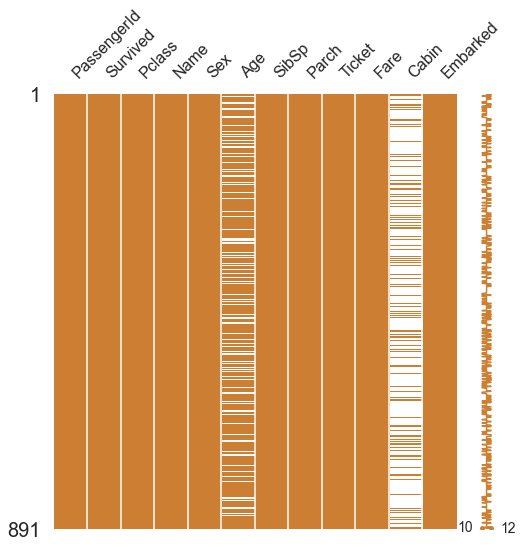

In [8]:
msno.matrix(
    df=df_train.iloc[:, :], 
    figsize=(8, 8), 
    color=(0.8, 0.5, 0.2)
)

<AxesSubplot:>

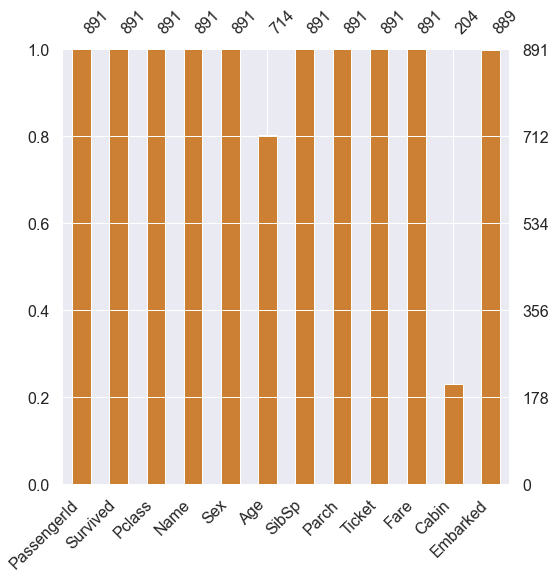

In [9]:
msno.bar(
    df=df_train.iloc[:,:],
    figsize=(8,8),
    color=(0.8,0.5,0.2)
)

<AxesSubplot:>

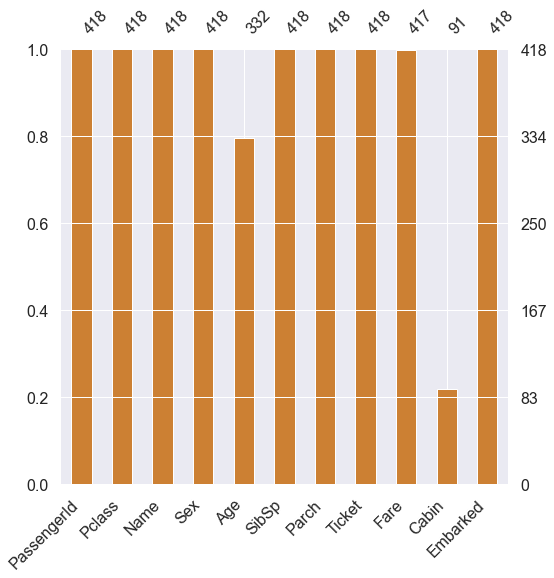

In [10]:
msno.bar(
    df=df_test.iloc[:, :], 
    figsize=(8, 8), 
    color=(0.8, 0.5, 0.2)
)

### 1.2 Target label 확인

- target label이 어떤 distribution을 가지고 있는지 확인해봐야 합니다.
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있습니다.

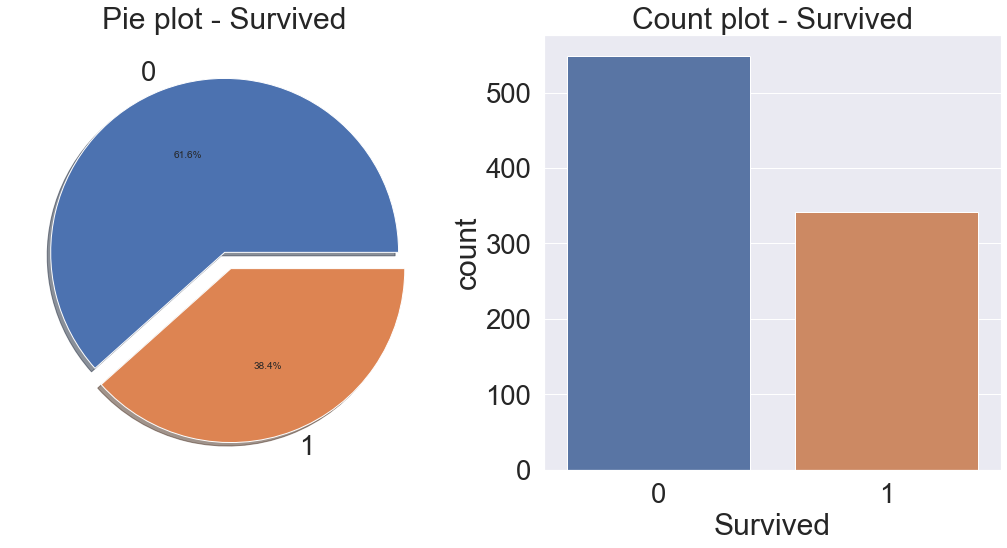

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')

sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

- 사망인원(0)이 생존인원(1)보다 많습니다.
- 38.4%가 살아남았습니다.
- target label의 분포가 제법 균일(balanced)합니다.
  - 불균일한 경우, 원하는 모델을 얻을 수 없어 여러가지 방법을 적용합니다.

## 2. Exploratory data analysis

- 이제 본격적으로 데이터 분석을 해보겠습니다.
- 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다.
  - 특정 목적에 맞는 소스코드를 정리하여 필요할 때마다 참고하면 편합니다.

### 2.1 Pclass

- 먼저 Pclass에 대해서 살펴보겠습니다. Pclass는 ordinal, 서수형 데이터입니다.
  - 카테고리이면서, 순서가 있는 데이터 타입입니다.
- Pclass에 따른 생존률의 차이를 살펴보겠습니다.
  - pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있습니다.
  - 또한 pivot이라는 메소드도 있습니다.
- 먼저 'Pclass', 'Survived'를 가져오 후, pclass로 묶습니다.
  - 그러면 각 pclass마다 0, 1이 count가 되는데, 이를 평균내면 각 pclass 별 생존률이 나옵니다.

In [12]:
df_train[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=True
).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=True
).sum()

,Survived
Pclass,
1,136
2,87
3,119


- pandas의 crosstab을 사용하면 좀 더 위 과정을 수월하게 볼 수 있습니다.

In [14]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).\
    style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [15]:
df_train[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=True
).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass'>

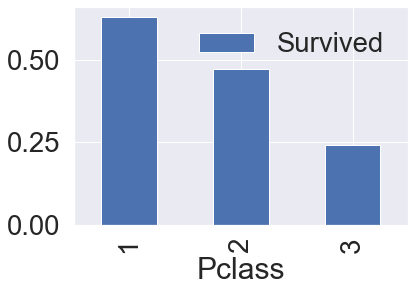

In [16]:
df_train[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=True
).mean().sort_values(by='Survived', ascending=False).plot.bar()

- Pclass가 좋을(작을) 수록 생존률이 높은 것을 확인할 수 있습니다.
- 좀 더 보기 쉽게 그래프를 그려보겠습니다.
  - seaborn countplot을 사용하면, 특정 label에 따른 개수를 확인해 볼 수 있습니다.

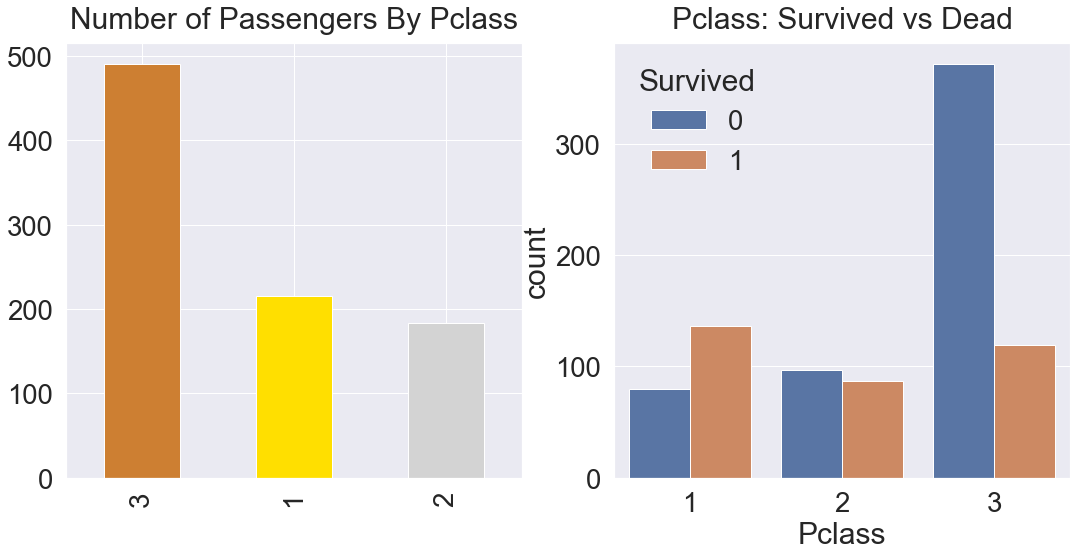

In [17]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Pclass'].value_counts().plot.bar(
    color=['#CD7F32', '#FFDF00', '#D3D3D3'],
    ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)

sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)

plt.show()

- 클래스가 높을 수록, 생존 확률이 높은걸 확인할 수 있습니다. Pclass 1, 2, 3 순서대로 63%, 48%, 25% 입니다.
- 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해 볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단할 수 있습니다.

### 2.2 Sex

- 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보겠습니다.

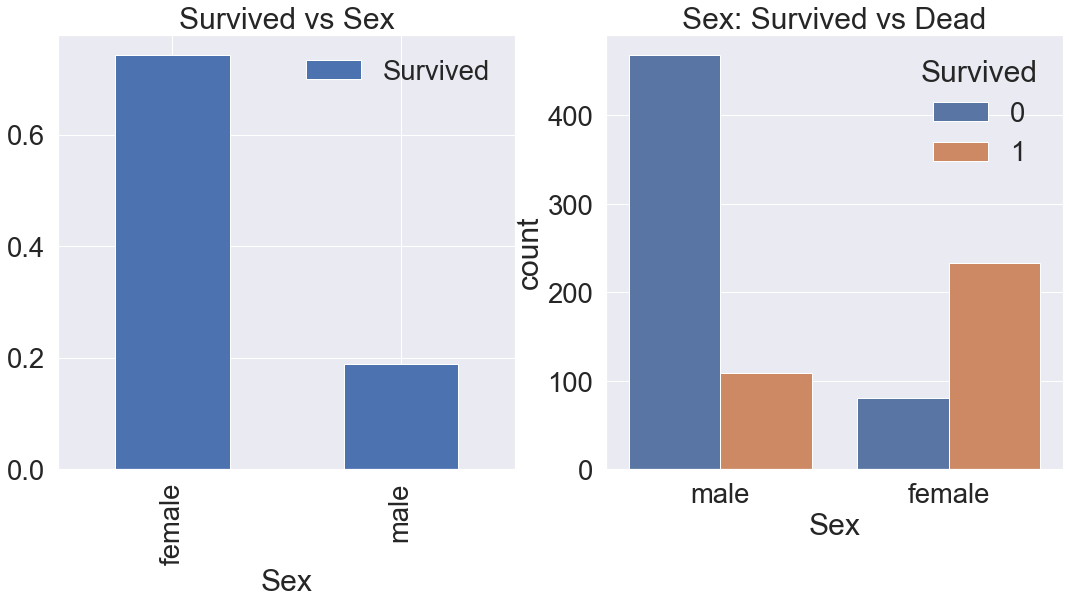

In [18]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train[['Sex', 'Survived']].groupby(
    ['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')

plt.show()

- 보시다시피, 여자가 생존할 확률이 더 높습니다.

In [19]:
df_train[['Sex', 'Survived']].\
    groupby(['Sex'], as_index=False).\
    mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [20]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).\
    style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있습니다.

### 2.3 Both Sex and Pclass

- 이번에는 Sex, Pclass 두 가지에 관하여 생존이 어떻게 달라지는지 확인해 봅시다.
- seaborn의 factorplot을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

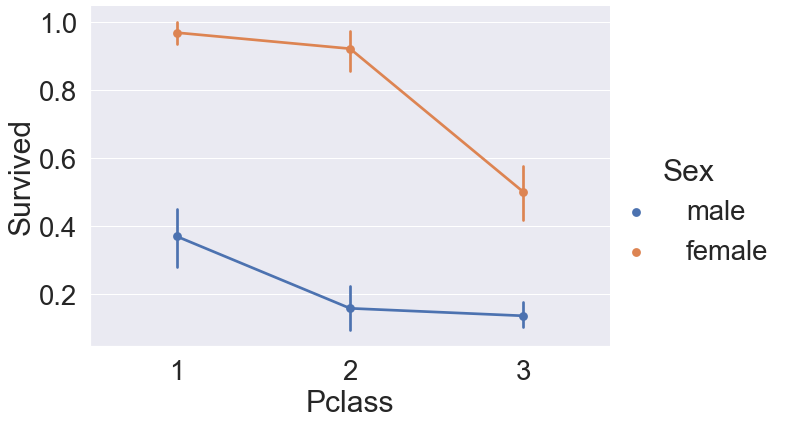

In [21]:
sns.factorplot(
    'Pclass', 'Survived', 
    hue='Sex', 
    data=df_train, 
    size=6, aspect=1.5)

- 모든 클래스에서 female이 살 확률이 male보다 높은 걸 알 수 있습니다.
- 또한 남자, 여자 상관없이 클래스가 높을수록 살 확률이 높습니다.
- 위 그래프는 hue 대신 column으로 하면 아래와 같아집니다.

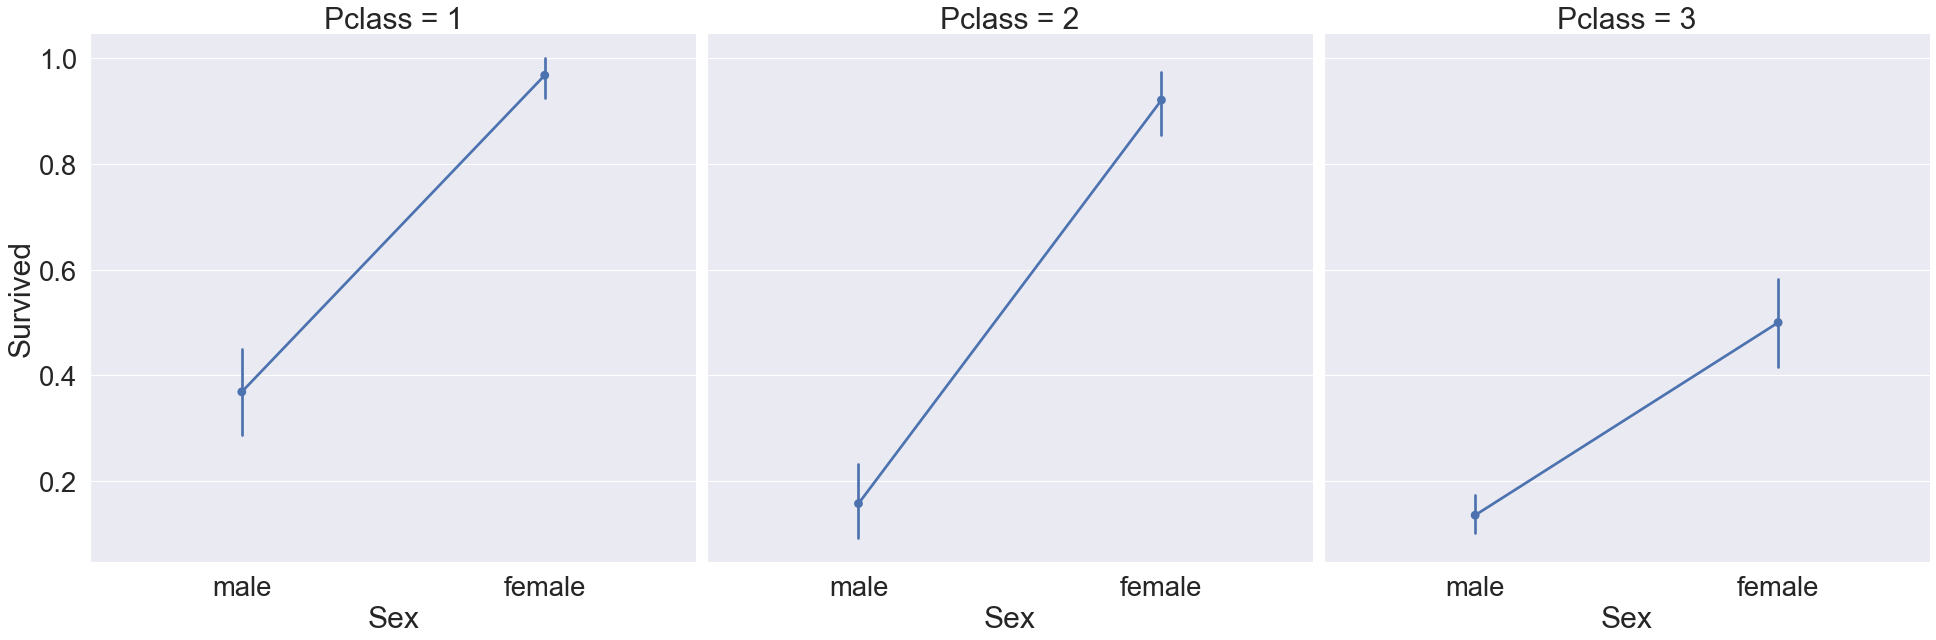

In [22]:
sns.factorplot(
    x='Sex', y='Survived', 
    col='Pclass', 
    data=df_train, 
    size=9, aspect=1)

### 2.4 Age

- 이번에는 Age feature를 살펴봅시다.

In [23]:
print('제일 나이가 많은 탑승객의 나이: {:.1f} Years'.format(
    df_train['Age'].max()))
print('제일 어린 탑승객의 나이: {:.1f} Years'.format(
    df_train['Age'].min()))
print('탑승객의 평균 나이: {:.1f} Years'.format(
    df_train['Age'].mean()))

제일 나이가 많은 탑승객의 나이: 80.0 Years
제일 어린 탑승객의 나이: 0.4 Years
탑승객의 평균 나이: 29.7 Years


- 생존에 따른 Age의 histogram을 그려보겠습니다.

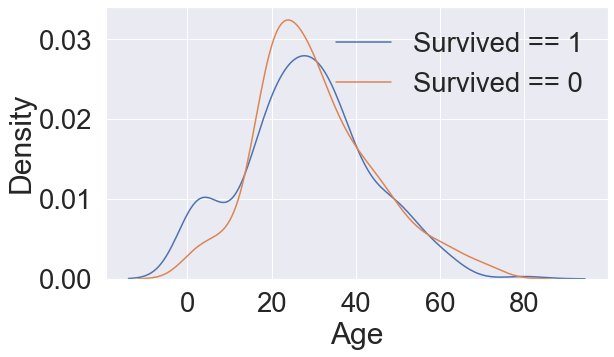

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])

plt.show()

- 생존자 중 나이가 어린 경우가 많음을 확인할 수 있습니다.

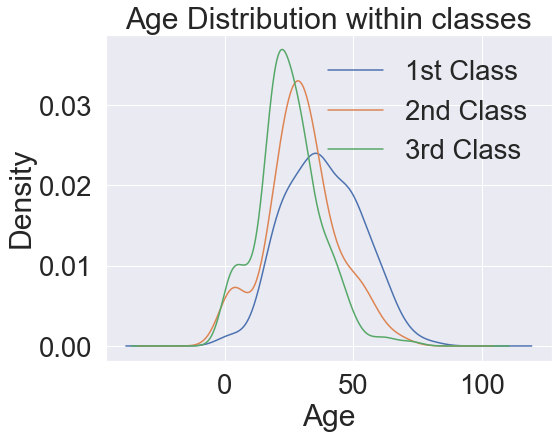

In [25]:
# Age distribution withing classes
plt.figure(figsize=(8, 6))

df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- class가 높을 수록 나이 많은 사람의 비중이 커집니다.
- 나이대가 변하면서 생존률이 어떻게 되는지 보려고 합니다.
- 나이 범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다.

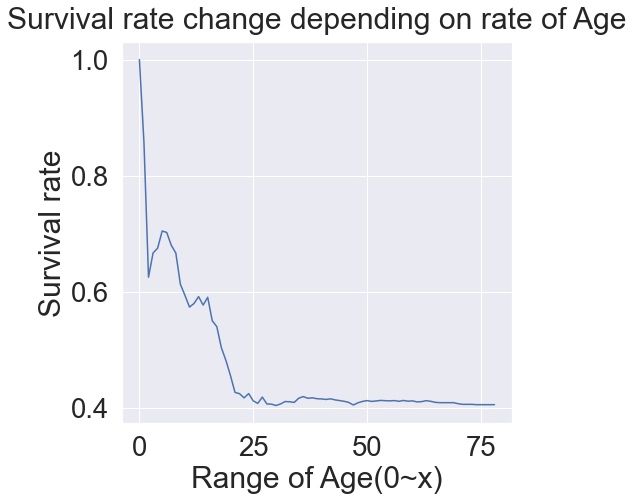

In [26]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(
        df_train[df_train['Age'] < i]['Survived'].sum() / \
        len(df_train[df_train['Age'] < i]['Survived']))
    
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on rate of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')

plt.show()

- 보시다시피, 나이가 어릴수록 생존률이 확실히 높은 것을 확인할 수 있습니다.
- 우리는 이 나이가 중요한 Feature로 쓰일 수 있음을 확인했습니다.

### 2.5 Pclass, Sex, Age

- 지금까지 본 Features에 모두에 대해서 시각화를 하고 싶습니다.
  - 이를 쉽게 그려주는 것이 seaborn의 violinplot 입니다.
  - x축은 우리가 나눠서 보고 싶어하는 case(여기선 Pclass, Sex)를 나타내고,
  - y축은 보고 싶어하는 distribution(Age) 입니다.

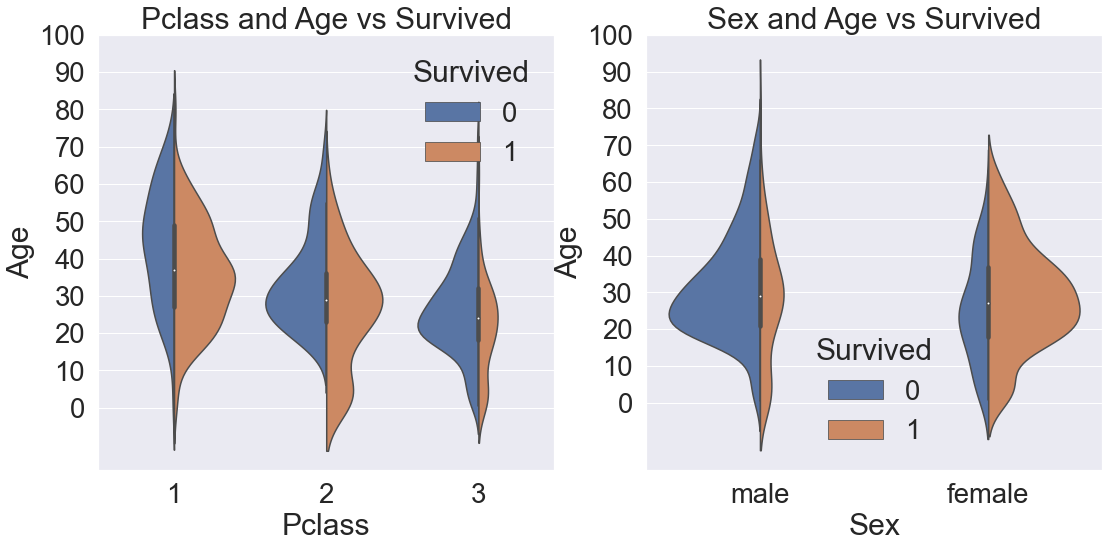

In [27]:
f, ax = plt.subplots(1,2,figsize=(18,8))

sns.violinplot(
    "Pclass", "Age", 
    hue="Survived", data=df_train, 
    scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot(
    "Sex", "Age", 
    hue="Survived", data=df_train,
    scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))

plt.show()

- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있습니다.
- 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한 것을 볼 수 있습니다.
- 결론: 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다.

### 2.6 Embarked

- Embarked는 탑승한 항구를 나타냅니다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

In [28]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<AxesSubplot:xlabel='Embarked'>

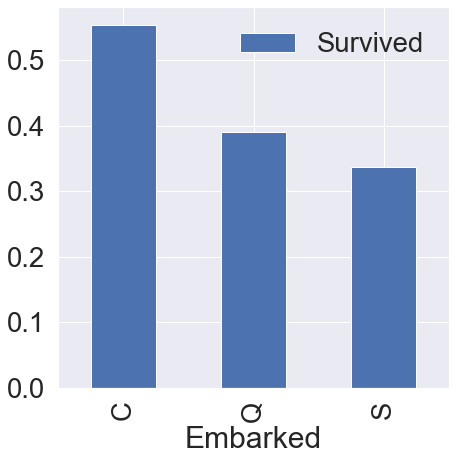

In [29]:
f, ax = plt.subplots(1, 1, figsize=(7,7))

df_train[['Embarked', 'Survived']]\
    .groupby(['Embarked'], as_index=True)\
    .mean().sort_values(by='Survived', ascending=False)\
    .plot.bar(ax=ax)

- 조금의 차이가 있지만 생존률은 거의 비슷한 것 같습니다. 그래도 C가 제일 높습니다.
  - 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
- 사실 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 살펴볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것 입니다.

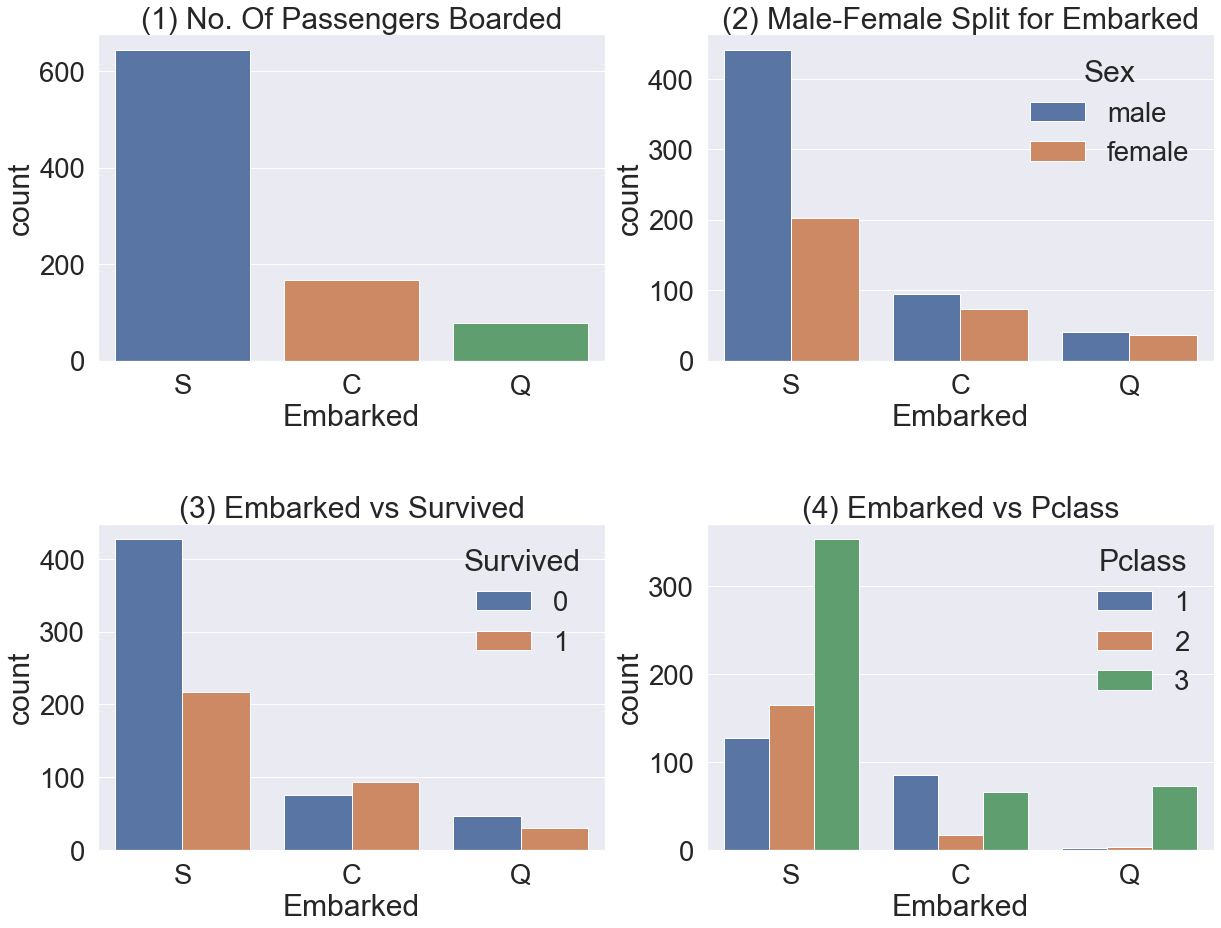

In [30]:
f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### 2.7 Family - SibSp (형제 자매) + Parch(부모, 자녀)

- SibSp와 Parch를 합하면 Family가 될 것입니다.
- Family로 합쳐서 분석해봅시다.

In [31]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [32]:
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize와 생존의 관계를 살펴봅시다.

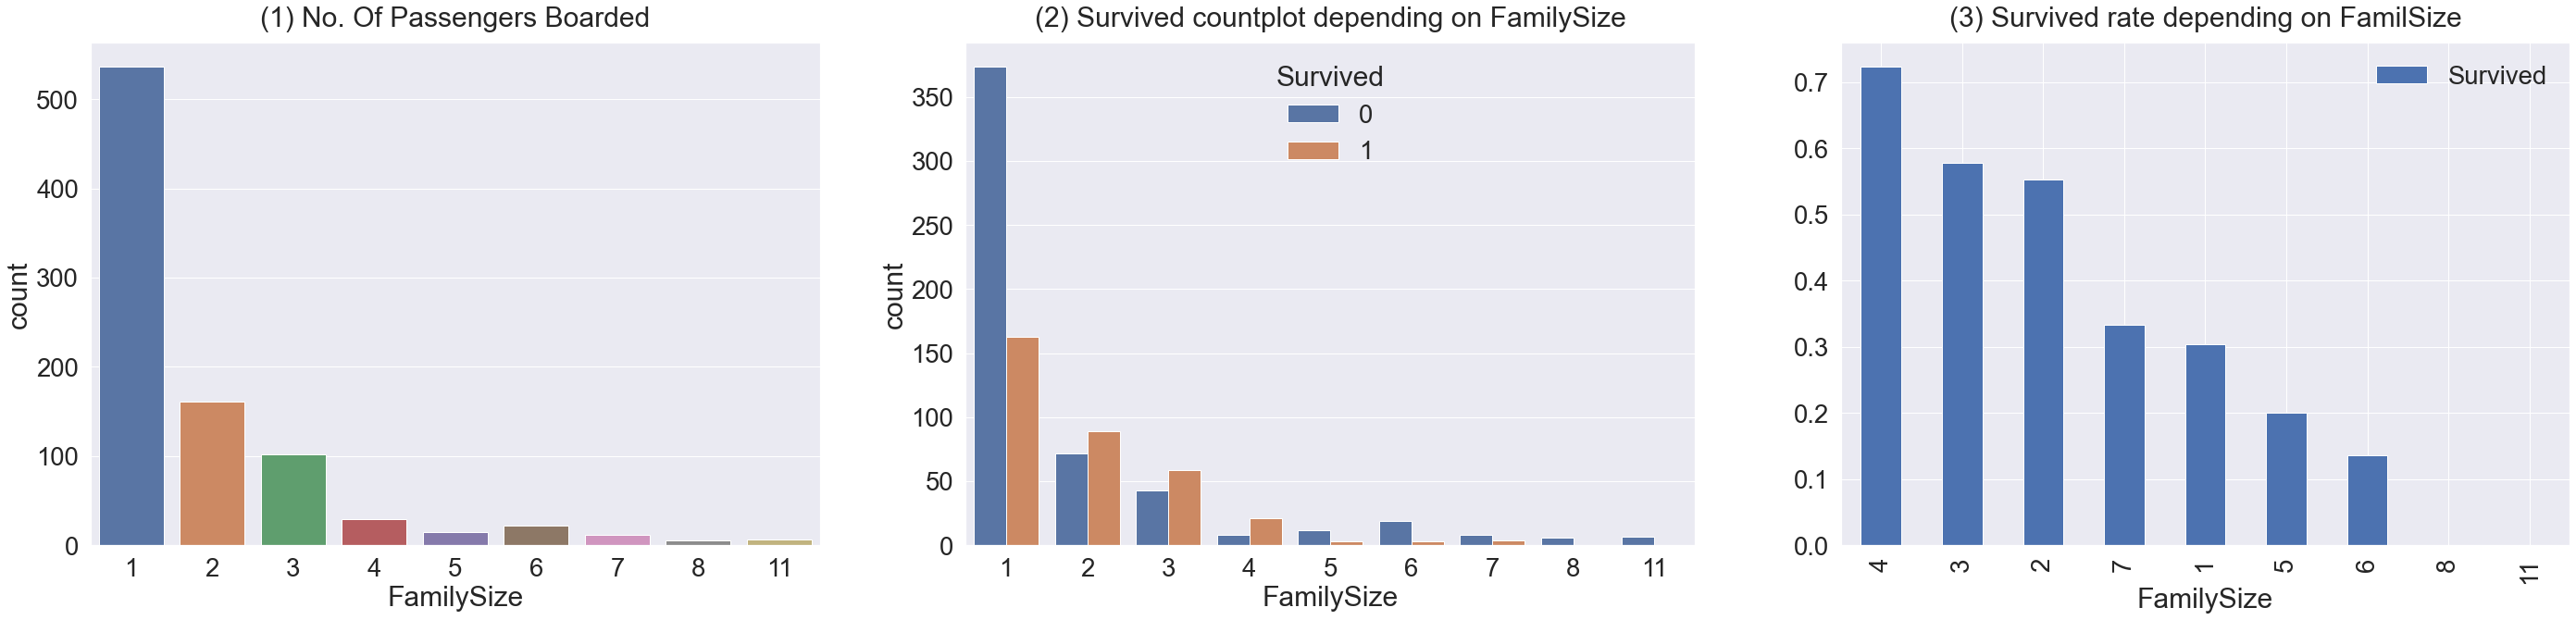

In [33]:
f, ax = plt.subplots(1, 3, figsize=(48, 10))

sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize', 'Survived']]\
    .groupby(['FamilySize'], as_index=True)\
    .mean().sort_values(by='Survived', ascending=False)\
    .plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilSize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure (1) - 가족크기가 1~11의 범위를 가짐을 알 수 있습니다. 대부분 1명이고, 그 다음으로 2, 3, 4 명입니다.
- Figure (2), (3) - 가족 크기에 따른 생존률 비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다.

### 2.8 Fare

- Fare는 탑승요금이며, contious feature입니다.
- 한번 histogram을 그려보겠습니다.

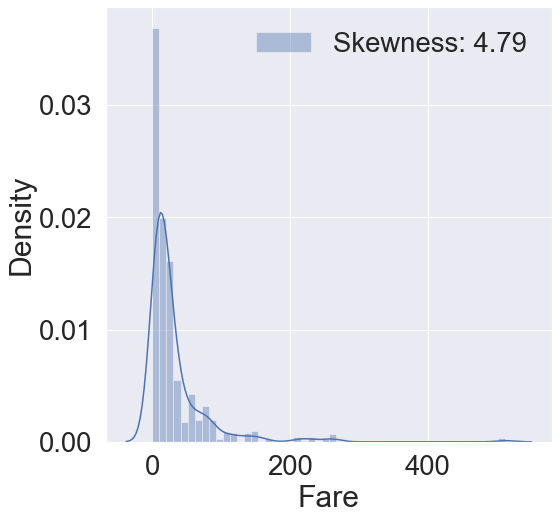

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

g = sns.distplot(
    df_train['Fare'], color='b', 
    label='Skewness: {:.2f}'.format(df_train['Fare'].skew()),
    ax=ax)

g = g.legend(loc='best')

- 보시다시피, distribution이 매우 비대칭인 것을 알 수 있습니다. (high skewness)
  - 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있습니다.
  - 몇개 없는 outlier에 대해서 너무 민감하게 반응한다면, 실제 예측 시에 좋지 못한 결과를 부를 수 있습니다.
- outlier의 영향을 줄이기 위해 Fare에 log를 취하겠습니다.
  - pandas의 map, 또는 apply를 취하면 특정 columns에 공통된 작업을 수행하기 쉽습니다.

In [35]:
# testset 에 있는 nan value 를 평균값으로 치환합니다.
df_test.loc[df_test.Fare.isnull(), 'Fare'] = \
    df_test['Fare'].mean() 

df_train['Fare'] = df_train['Fare'].map(
    lambda i: np.log(i) if i > 0 else 0)

df_test['Fare'] = df_test['Fare'].map(
    lambda i: np.log(i) if i > 0 else 0)

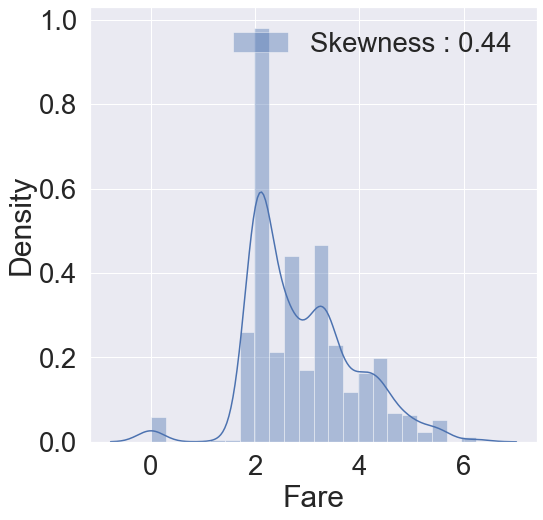

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- log를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
  - 우리는 이런 작업을 통해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
  - 사실 방금한 것은 feature engineering에 해당하는 부분입니다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 하는데, 우리는 이제 그것을 살펴볼 것입니다.

### 2.9 Cabin

- 이 Feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지 않습니다.
- 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

### 2.10 Ticket

- 이 feature 는 NaN 은 없습니다. 일단 string data 이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다.

In [37]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

## 3. Feature Engineering

- 본격적인 feature engineering을 시작해보겠습니다.
- 가장 먼저, dataset에 존재하는 null data를 채우려고 합니다.
  - 아무 숫자로 채울수는 없고, null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내 채울 수 있습니다.
  - null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야 할 부분입니다.
- Feature engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, train뿐 아니라 test도 똑같이 적용해 주어야 한다는 사실을 잊지 맙시다.

### 3.1 Fill Null
#### 3.1.1 Fill Null in Age using title

- Age에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics를 사용해보겠습니다.
  - 영어권에서는 Miss, Mrr, Mrs와 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 존재하므로 이를 사용해보겠습니다.
  - pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.
  


In [38]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [39]:
pd.crosstab(df_train['Initial'], df_train['Sex'])\
    .T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [40]:
df_train['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True)

df_test['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],
    inplace=True)

In [41]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss, Mr, Mrs가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

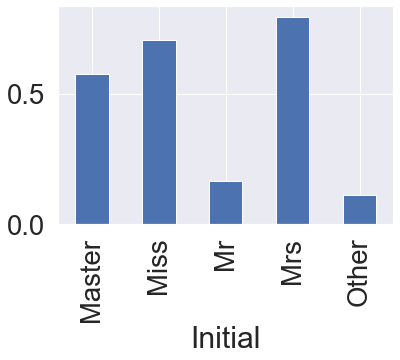

In [42]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null을 채울 것입니다. Null data를 채우는 방법은 정말 많이 존재합니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [43]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null를 채우도록 하겠습니다.
- Pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age'값을 33으로 치환한다 입니다.
- loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [44]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

#### 3.1.2 Fill Null in Embarked

In [45]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


- Embarked는 Null values가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다.
- dataframe의 filling method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [46]:
df_train['Embarked'].fillna('S', inplace=True)

In [47]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  0  Null values


### 3.2 Change Age (continuous to categorical)

- Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있지만 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행해보겠습니다.
- 방법은 여러가지가 있습니다.
  - dataframe의 indexing 방법인 loc를 사용해 직접해줄 수 있고, 아니면 apply를 통해 함수를 넣어줄 수도 있습니다.

In [48]:
# loc를 이용한 방법
df_train['Age_cat'] = 0 

for age in range(0, 70, 10):
    print('Age Category: [{},{}) - {}'.format(age, age + 10, age//10))
    df_train.loc[
        (age <= df_train['Age'])&(df_train['Age']< age + 10), 'Age_cat'] = age//10

df_train.loc[
        (70 <= df_train['Age']), 'Age_cat'] = 7


Age Category: [0,10) - 0
Age Category: [10,20) - 1
Age Category: [20,30) - 2
Age Category: [30,40) - 3
Age Category: [40,50) - 4
Age Category: [50,60) - 5
Age Category: [60,70) - 6


In [49]:
# apply 메소드를 이용한 방법
df_train['Age_cat_2'] = df_train['Age']\
    .apply(lambda n: int(n//10) if n < 70 else 7)

- 두 가지 방법이 잘 적용되었다면, 둘다 같은 결과를 내야합니다.
- 이를 확인하기 위해 Series간 boolean 비교 후 all() 메소드를 사용합시다.
  - all() 메소드는 모든 값이 True면 True, 하나라도 False가 있으면 False를 줍니다.

In [50]:
print((df_train['Age_cat'] == df_train['Age_cat_2']).all())

True


- 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [51]:
df_train['Age_cat'] = df_train['Age']\
    .apply(lambda n: int(n//10) if n < 70 else 7)
df_test['Age_cat'] = df_test['Age']\
    .apply(lambda n: int(n//10) if n < 70 else 7)

df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### 3.3 Change Initial, Embarked and Sex (string to numerical)

- 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
- map method 를 가지고 간단히 할 수 있습니다.
  - 사전 순서대로 정리하여 mapping 하겠습니다

In [52]:
df_train['Initial'] = df_train['Initial'].map({
    'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

df_test['Initial'] = df_test['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

- Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
- 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [53]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [54]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [55]:
df_train['Embarked'] = df_train['Embarked'].map(
    {'C': 0, 'Q': 1, 'S': 2})

df_test['Embarked'] = df_test['Embarked'].map(
    {'C': 0, 'Q': 1, 'S': 2})

- 한번 Null 이 사라졌는지 확인해봅시다. 
- Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [56]:
df_train['Embarked'].isnull().any()

False

- Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [57]:
df_train['Sex'] = df_train['Sex'].map(
    {'female': 0, 'male': 1})

df_test['Sex'] = df_test['Sex'].map(
    {'female': 0, 'male': 1})

- 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

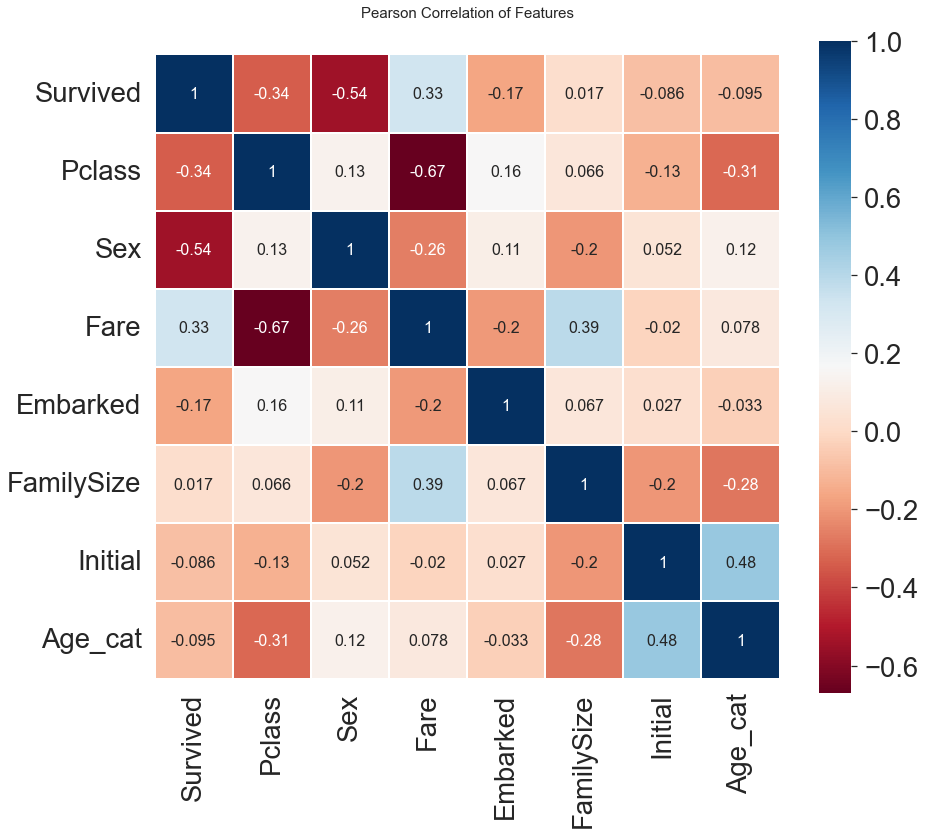

In [58]:
heatmap_data = df_train[
    ['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

- 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
- 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
- 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
- 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다. 거의 다 와갑니다 힙냅시다!

## 3.4 One-hot encoding on Initial and Embarked

- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.

In [59]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [60]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다
- Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [61]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 아주 쉽게 one-hot encoding 을 적용했습니다.
- sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
  - 다른 튜토리얼에서 한번 써보겠습니다. 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠습니다.
- 가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5 Drop columns

- 필요한 columns만 남기고 다 지웁시다!

In [62]:
df_train.drop(
    ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(
    ['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [63]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


## 4. Building machine learning model and prediction using the trained model

In [64]:
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

- Sklearn 은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.
- 파이썬 라이브러리를 활용한 머신러닝(Introduction to machine larning with Python)책을 사서 공부하시길 매우 추천해드립니다.
- 지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.
- 우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.
- 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

### 4.1 Preparation - Split dataset into train, valid, test set

- 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.


In [65]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values

X_test = df_test.values

- 보통 train, test만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
- train_test_split을 사용하여 쉽게 train셋을 분리할 수 있습니다.

In [66]:
X_tr, X_vld, y_tr, y_vld = \
    train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 더 구체적인 모델 설명은 여러 블로그들 참고하시면 될 것이고, 저도 한번 추후 다뤄보겠습니다.
- 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠. 그래서 캐글을 추천합니다. 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생길테니까요!
- 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.
- 모델 객체를 만들고, fit 메소드로 학습시킵니다.
- 그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

### 4.2 Model generation and prediction

In [67]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)

prediction = model.predict(X_vld)

In [68]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(
    y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)
))

총 268명 중 81.34% 정확도로 생존을 맞춤


- 아무런 파라미터 튜닝도 하지 않았는데 82%의 정확도가 나왔습니다. 고생하셨습니다!

### 4.3 Feature importance

- 학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.
- 쉽게 말해, 10 = 4x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.
- 학습된 모델은 기본적으로 featureimportances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
- pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

In [69]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

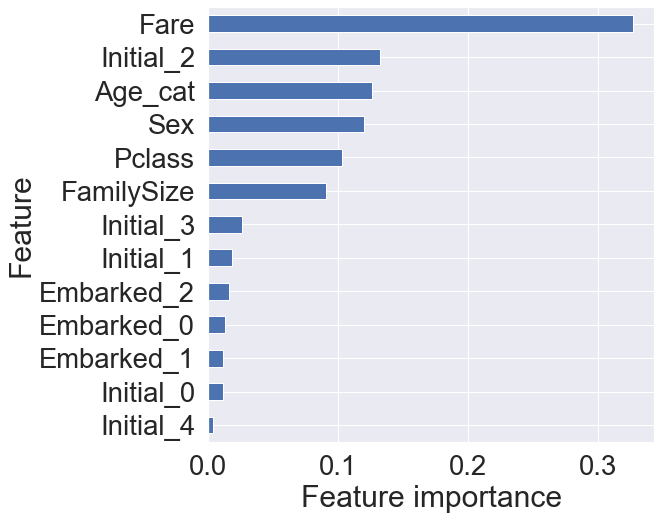

In [72]:
plt.figure(figsize=(8, 8))

Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')

plt.show()

- 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다
- 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.
- 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
- featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.